# TP de Graphe :
# 1.1 Construction du graphe

In [1]:
import matplotlib.pyplot as plt

class Graphe:
    def __init__(self):
        self.graphe = {}
        self.depart = None
        self.arrivee = None
        self.non_connectables = set()  # Initialisation de non_connectables


    def ajouter_sommet(self, sommet):
        x, y = sommet
        connectable = self.matrice[y][x] != '0'
        if sommet not in self.graphe:
            self.graphe[sommet] = set()
            if not connectable:
                self.non_connectables.add(sommet)


    def ajouter_arete(self, u, v):
        if u in self.graphe and v in self.graphe and u not in self.non_connectables and v not in self.non_connectables:
            self.graphe[u].add(v)
            self.graphe[v].add(u)
            print(f"Arête ajoutée entre {u} et {v}")


    def supprimer_arete(self, u, v):
        if u in self.graphe and v in self.graphe:
            self.graphe[u].discard(v)
            self.graphe[v].discard(u)

    def creer_graphe_depuis_fichier(self, chemin_fichier):
        with open(chemin_fichier, 'r') as fichier:
            lignes = fichier.readlines()

        n, m = map(int, lignes[0].split())
        self.matrice = [ligne.split() for ligne in lignes[1:]]

        for y in range(n):
            for x in range(m):
                if self.matrice[y][x] == '2':
                    self.depart = (x, y)
                if self.matrice[y][x] == '3':
                    self.arrivee = (x, y)
                self.ajouter_sommet((x, y))

    
    def afficher_matrice(self):
        # Déterminer la taille de la matrice
        max_x = max(self.graphe, key=lambda x: x[0])[0] + 1
        max_y = max(self.graphe, key=lambda x: x[1])[1] + 1
        
        # Initialiser la matrice avec des zéros
        matrice = [['0' for _ in range(max_x)] for _ in range(max_y)]
        
        # Remplir la matrice avec les chemins (1), départ (2) et arrivée (3)
        for (x, y) in self.graphe:
            matrice[y][x] = '1'
        if self.depart:
            matrice[self.depart[1]][self.depart[0]] = '2'
        if self.arrivee:
            matrice[self.arrivee[1]][self.arrivee[0]] = '3'
        
        # Afficher la matrice
        for ligne in matrice:
            print(' '.join(ligne))

    def tracer_graphe(self):
        plt.figure(figsize=(8, 6))
        # Dessiner les arêtes
        for u in self.graphe:
            for v in self.graphe[u]:
                plt.plot([u[0], v[0]], [u[1], v[1]], 'b-', linewidth=1)

        # Dessiner les sommets
        for u in self.graphe:
            color = 'grey' if u in self.non_connectables else 'black'
            plt.plot(u[0], u[1], 'o', color=color, markersize=8)

        # Mettre en évidence les points de départ et d'arrivée
        if self.depart:
            plt.plot(self.depart[0], self.depart[1], 'go', markersize=10)
        if self.arrivee:
            plt.plot(self.arrivee[0], self.arrivee[1], 'ro', markersize=10)

        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.title('Visualisation du Graphe')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.show()


# Exemple d'utilisation

# Usage example
graphe = Graphe()
graphe.creer_graphe_depuis_fichier('exo1.txt')  # Assurez-vous que le chemin d'accès est correcte


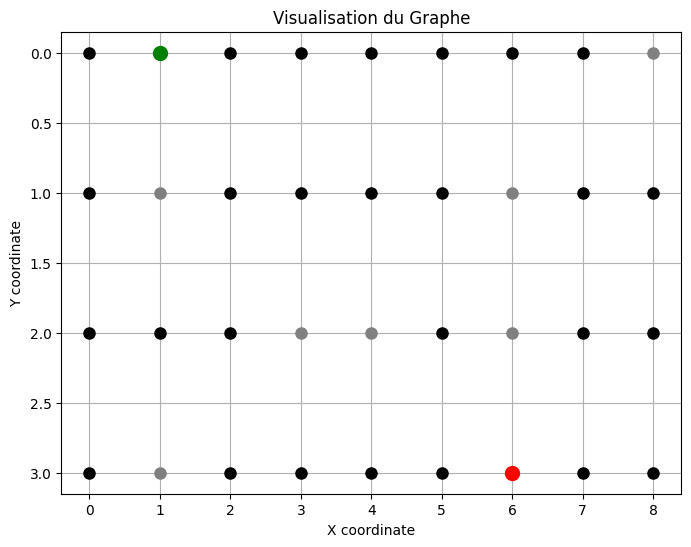

In [2]:
graphe.tracer_graphe()

Arête ajoutée entre (0, 0) et (0, 1)
Arête ajoutée entre (0, 0) et (1, 0)
Arête ajoutée entre (1, 0) et (2, 0)


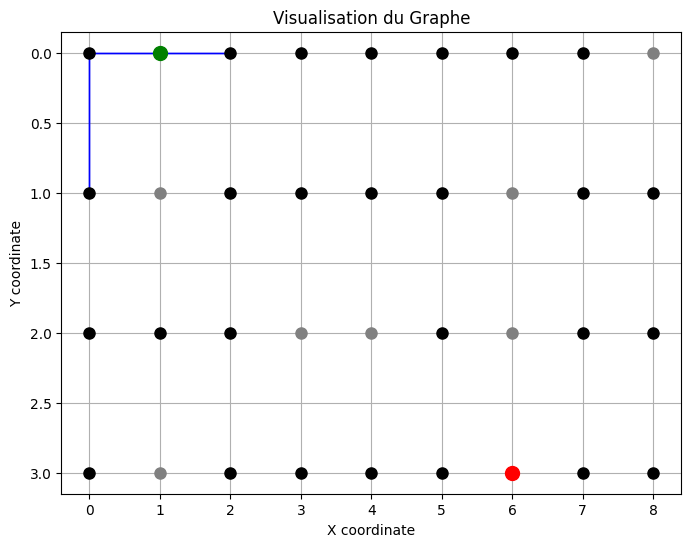

In [3]:
# Colonne en premier et ligne en deuxième pour chaque coordonnées.
graphe.ajouter_arete((1,2),(1,1))
graphe.ajouter_arete((0, 0), (0, 1))
graphe.ajouter_arete((0, 0), (1, 0))
graphe.ajouter_arete((1, 0), (2, 0))
graphe.ajouter_arete((1, 0), (1, 1))
graphe.tracer_graphe()


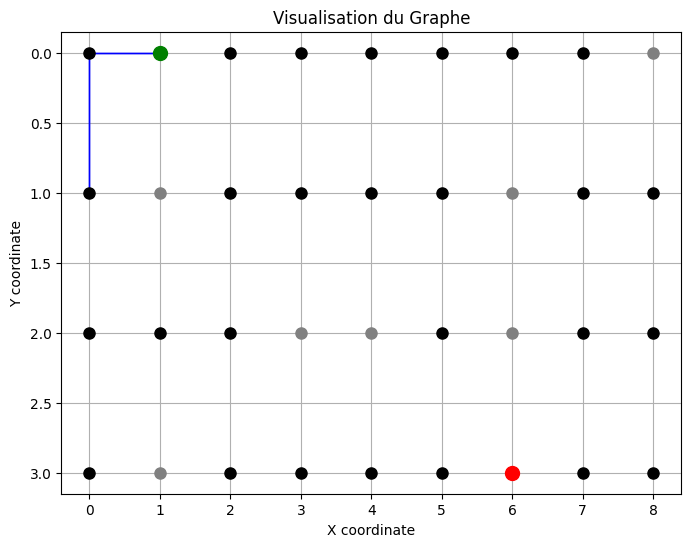

In [4]:
# Test suppression
graphe.supprimer_arete((1, 0), (2, 0))
graphe.tracer_graphe()


# 1.2 Modélisation mathématique

## Modélisation du Problème en Programmation Linéaire

Le problème du plus court chemin dans un graphe peut être formulé comme un problème de programmation linéaire. Ce problème consiste à trouver le chemin le moins coûteux entre une source et une destination dans un graphe.

### Variables
Pour chaque arête $(u, v)$ dans le graphe, nous définissons une variable binaire $x_{uv}$ qui indique si l'arête $(u, v)$ est utilisée dans le chemin le plus court.

### Fonction Objectif
La fonction objectif est de minimiser le coût total du chemin. Cela est exprimé comme suit :

$$ \min \sum_{(u, v) \in E} c_{uv} x_{uv} $$

où $c_{uv}$ représente le coût de l'arête $(u, v)$.

### Contraintes

#### Conservation du Flux
Pour chaque sommet $v$ autre que la source $s$ et la destination $t$, la conservation du flux doit être respectée :

$$ \sum_{(u, v) \in E} x_{uv} - \sum_{(v, w) \in E} x_{vw} = 0 $$

#### Contraintes de la Source et de la Destination
La source $s$ doit avoir exactement une arête sortante active et la destination $t$ doit avoir exactement une arête entrante active :

- Pour la source $s$ :
$$ \sum_{(s, v) \in E} x_{sv} = 1 $$

- Pour la destination $t$ :
$$ \sum_{(u, t) \in E} x_{ut} = 1 $$

## Résumé
Cette modélisation permet de transformer le problème du plus court chemin en un problème de programmation linéaire, où la solution optimale indique le chemin le plus court en termes de coût entre deux points donnés dans un réseau.


## Implémentation avec CPLEX

In [5]:
from cplex import Cplex
from cplex.exceptions import CplexError

def resoudre_cplex(graphe):
    try:
        prob = Cplex()
        prob.set_problem_type(Cplex.problem_type.LP)  # Définir le problème comme linéaire

        # Ajouter les variables x_uv
        edge_vars = []
        for u in graphe.graphe:
            for v in graphe.graphe[u]:
                varname = f"x_{u}_{v}"
                prob.variables.add(names=[varname], lb=[0], ub=[1], types=["B"])
                edge_vars.append((varname, u, v))

        # Définir la fonction objectif
        prob.objective.set_sense(prob.objective.sense.minimize)
        costs = [1] * len(edge_vars)  # Mettre les coûts ici, 1 pour exemple simplifié
        varnames = [var[0] for var in edge_vars]
        prob.objective.set_linear(list(zip(varnames, costs)))

        # Ajouter les contraintes de conservation du flux
        for node in graphe.graphe:
            if node != graphe.depart and node != graphe.arrivee:
                row = [[], []]
                for varname, u, v in edge_vars:
                    if u == node:
                        row[0].append(varname)
                        row[1].append(1)
                    if v == node:
                        row[0].append(varname)
                        row[1].append(-1)
                prob.linear_constraints.add(lin_expr=[row], senses=["E"], rhs=[0])

        # Contraintes pour la source et la destination
        source_constraints = [[], []]
        sink_constraints = [[], []]
        for varname, u, v in edge_vars:
            if u == graphe.depart:
                source_constraints[0].append(varname)
                source_constraints[1].append(1)
            if v == graphe.arrivee:
                sink_constraints[0].append(varname)
                sink_constraints[1].append(1)
        prob.linear_constraints.add(lin_expr=[source_constraints], senses=["E"], rhs=[1])
        prob.linear_constraints.add(lin_expr=[sink_constraints], senses=["E"], rhs=[1])

        prob.solve()  # Résoudre le problème

        # Afficher la solution
        solution = prob.solution.get_values()
        for idx, value in enumerate(solution):
            if value > 0.9:  # Si x_uv est 1
                print(f"{edge_vars[idx]} is in the solution")

    except CplexError as exc:
        print(exc)
        return

resoudre_cplex(graphe)


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Infeasibility row 'c36':  0  = 1.
Presolve time = 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.00 ticks)


CPLEX Error  1217: No solution exists.


CPLEX Error  1217: No solution exists.


## Sauvegarde de la solution

In [6]:
def sauvegarder_solution(graphe, solution, nom_fichier_source):
    nom_fichier_solution = "sol_" + nom_fichier_source

    with open(nom_fichier_solution, "w") as fichier:
        fichier.write("Chemin le plus court du sommet {} au sommet {}:\n".format(graphe.depart, graphe.arrivee))
        for u in graphe.graphe:
            for v in graphe.graphe[u]:
                # On vérifie si l'arête (u, v) est utilisée dans la solution (x_uv = 1)
                if solution.get(f"x_{u}_{v}", 0) > 0.9:  # supposer que x_{u, v} est la clé dans le dictionnaire solution
                    fichier.write(f"{u} -> {v}\n")